# XGBoost GPU Benchmarks

In this notebook, we benchmark the latest version of [XGBoost](https://github.com/dmlc/xgboost), the well-known Kaggle-winning gradient boosting algorithm, and in particular, the [XGBoost GPU plugin](https://github.com/dmlc/xgboost/blob/master/plugin/updater_gpu/README.md).
In addition, we showcase the H2O integration of XGBoost.

In [1]:
#!easy_install http://s3.amazonaws.com/h2o-deepwater/public/nightly/latest/xgboost-0.6-py2.7.egg ## for python 2
#!easy_install http://s3.amazonaws.com/h2o-deepwater/public/nightly/latest/xgboost-0.6-py3.5.egg ## for python 3
#!pip install http://s3.amazonaws.com/h2o-deepwater/public/nightly/latest/h2o-3.11.0-py2.py3-none-any.whl

In [2]:
%matplotlib inline
import xgboost as xgb
import pandas as pd
import numpy as np
import scipy as sp
import os
import time
from sklearn import metrics
import feather as ft

/home/arno/.pyenv/versions/3.6.0/lib/python3.6/json/encoder.py:199: DeprecationWarning: Interpreting naive datetime as local 2017-06-12 11:42:05.286490. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


In [3]:
if False:
    ## Kaggle dataset - download from 
    ## https://www.kaggle.com/c/santander-customer-satisfaction/data
    path = "/home/arno/kaggle/santander/data/train.csv"
    target = "TARGET"
    trainrows=60000
    drop_cols=["ID"]
    num_class = 2
    num_round = 200
    learn_rate = 0.02
    max_depth = 8

    ## Parse data into a Pandas Frame
    t_start = time.time()
    df = pd.read_csv(path)
    if drop_cols is not None:
        df = df.drop(drop_cols, axis=1)
    print("Time to parse by Pandas (sec): ", time.time() - t_start)

    df_target = df[target]
    df = df.drop(target, axis=1)
    cols = df.columns.values
    df.shape
if False:
    ## Airline dataset
    ## https://s3.amazonaws.com/h2o-public-test-data/bigdata/laptop/airlines_all.05p.csv"
    path = "/home/arno/h2o-3/bigdata/laptop/airlines_all.05p.csv"
    target = "IsDepDelayed"
    trainrows=3000000
    drop_cols=['ArrTime','DepTime','ActualElapsedTime','AirTime','ArrDelay',
               'DepDelay','TaxiIn', 'TaxiOut', 'Cancelled',
               'CancellationCode', 'Diverted', 'CarrierDelay', 
              'WeatherDelay', 'NASDelay', 'SecurityDelay', 'TailNum',
              'LateAircraftDelay', 'IsArrDelayed']
    header = None
    num_round = 100
    learn_rate = 0.02
    max_depth = 8
    num_class = 2

    ## Parse data into a Pandas Frame
    t_start = time.time()
    df = pd.read_csv(path,encoding= "ISO-8859-1")
    if drop_cols is not None:
        df = df.drop(drop_cols, axis=1)
    print("Time to parse by Pandas (sec): ", time.time() - t_start)

    df_target = df[target].replace(('YES', 'NO'), (1, 0))
    df = df.drop(target, axis=1)
    cols = df.columns.values
    df.shape

    from sklearn import preprocessing
    catcols = df.select_dtypes(include=['object'])
    cc = [x for x in list(catcols.columns)]
    for f in cc:
        df[f] = preprocessing.LabelEncoder().fit_transform(list(df[f].values))
if True:
    ## Airline dataset
    path = "/home/arno/ipums_2000-2015_head4M.csv"
    target = "INCEARN"
    trainrows=3000000
    drop_cols=[]
    num_round = 100
    learn_rate = 0.02
    max_depth = 8
    num_class = 1

    ## Parse data into a Pandas Frame
    if not os.path.exists("census.feather"):
        t_start = time.time()
        df = pd.read_csv(path,encoding= "ISO-8859-1")
        if drop_cols is not None:
            df = df.drop(drop_cols, axis=1)
        print("Time to parse by Pandas (sec): ", time.time() - t_start)
        ft.write_dataframe(df, 'census.feather')
    else:
        df = ft.read_dataframe('census.feather')
    df_target = df[target]
    df = df.drop(target, axis=1)
    cols = df.columns.values
    df.shape

    from sklearn import preprocessing
    catcols = df.select_dtypes(include=['object'])
    cc = [x for x in list(catcols.columns)]
    for f in cc:
        df[f] = preprocessing.LabelEncoder().fit_transform(list(df[f].values))

/home/arno/.pyenv/versions/3.6.0/lib/python3.6/json/encoder.py:199: DeprecationWarning: Interpreting naive datetime as local 2017-06-12 11:42:05.988599. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


In [4]:
train = df.iloc[:trainrows,:]
test  = df.iloc[trainrows:,:]
train_target = df_target.iloc[:trainrows].astype('float64')
test_target  = df_target.iloc[trainrows:].astype('float64')

/home/arno/.pyenv/versions/3.6.0/lib/python3.6/json/encoder.py:199: DeprecationWarning: Interpreting naive datetime as local 2017-06-12 11:42:28.784932. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


In [5]:
print(train.info())
print(test.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000000 entries, 0 to 2999999
Columns: 458 entries, RECTYPE to REPWTP80
dtypes: float64(260), int64(198)
memory usage: 10.2 GB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 3000000 to 3999999
Columns: 458 entries, RECTYPE to REPWTP80
dtypes: float64(260), int64(198)
memory usage: 3.4 GB
None


/home/arno/.pyenv/versions/3.6.0/lib/python3.6/json/encoder.py:199: DeprecationWarning: Interpreting naive datetime as local 2017-06-12 11:42:33.164187. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


In [6]:
print(train_target)
print(test_target)

0            4000.0
1           36700.0
2           54000.0
3             900.0
4            2000.0
5               0.0
6            8000.0
7            6100.0
8            2800.0
9           28000.0
10              0.0
11          11000.0
12              0.0
13          52000.0
14         125000.0
15              0.0
16              0.0
17          22001.0
18              0.0
19              0.0
20          20000.0
21          55000.0
22          35000.0
23          30000.0
24         120000.0
25              0.0
26              0.0
27           8400.0
28           5000.0
29              0.0
             ...   
2999970         0.0
2999971         0.0
2999972         0.0
2999973     25000.0
2999974      6000.0
2999975         0.0
2999976     40000.0
2999977     22000.0
2999978     70000.0
2999979         0.0
2999980         0.0
2999981         0.0
2999982     53000.0
2999983     18000.0
2999984         0.0
2999985     45000.0
2999986     45000.0
2999987         0.0
2999988         0.0


/home/arno/.pyenv/versions/3.6.0/lib/python3.6/json/encoder.py:199: DeprecationWarning: Interpreting naive datetime as local 2017-06-12 11:42:33.259415. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


In [7]:
!lscpu

Architecture:          x86_64
CPU op-mode(s):        32-bit, 64-bit
Byte Order:            Little Endian
CPU(s):                40
On-line CPU(s) list:   0-39
Thread(s) per core:    2
Core(s) per socket:    10
Socket(s):             2
NUMA node(s):          2
Vendor ID:             GenuineIntel
CPU family:            6
Model:                 79
Model name:            Intel(R) Xeon(R) CPU E5-2630 v4 @ 2.20GHz
Stepping:              1
CPU MHz:               2801.046
CPU max MHz:           3100.0000
CPU min MHz:           1200.0000
BogoMIPS:              4401.54
Virtualization:        VT-x
L1d cache:             32K
L1i cache:             32K
L2 cache:              256K
L3 cache:              25600K
NUMA node0 CPU(s):     0-9,20-29
NUMA node1 CPU(s):     10-19,30-39
Flags:                 fpu vme de pse tsc msr pae mce cx8 apic sep mtrr pge mca cmov pat pse36 clflush dts acpi mmx fxsr sse sse2 ss ht tm pbe syscall nx pdpe1gb rdtscp lm constant_tsc arch_perfmon pebs bts rep_good nopl xtopo

/home/arno/.pyenv/versions/3.6.0/lib/python3.6/json/encoder.py:199: DeprecationWarning: Interpreting naive datetime as local 2017-06-12 11:42:33.327155. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


In [8]:
!cat /proc/meminfo | grep MemTotal

MemTotal:       264019760 kB


/home/arno/.pyenv/versions/3.6.0/lib/python3.6/json/encoder.py:199: DeprecationWarning: Interpreting naive datetime as local 2017-06-12 11:42:33.507504. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


In [9]:
!nvidia-smi -L

GPU 0: GeForce GTX 1080 Ti (UUID: GPU-0eb406e1-1e7d-372f-c655-06fb94be3ea1)
GPU 1: GeForce GTX 1080 Ti (UUID: GPU-00bd4213-ce77-bfb8-012f-6600b2b105fa)


/home/arno/.pyenv/versions/3.6.0/lib/python3.6/json/encoder.py:199: DeprecationWarning: Interpreting naive datetime as local 2017-06-12 11:42:33.700346. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


In [10]:
!nvidia-smi

Mon Jun 12 11:42:33 2017       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 381.09                 Driver Version: 381.09                    |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce GTX 108...  Off  | 0000:02:00.0      On |                  N/A |
| 29%   47C    P8    23W / 250W |    725MiB / 11172MiB |     34%      Default |
+-------------------------------+----------------------+----------------------+
|   1  GeForce GTX 108...  Off  | 0000:81:00.0     Off |                  N/A |
| 25%   42C    P8    18W / 250W |      2MiB / 11172MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
        

/home/arno/.pyenv/versions/3.6.0/lib/python3.6/json/encoder.py:199: DeprecationWarning: Interpreting naive datetime as local 2017-06-12 11:42:33.895809. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


In [14]:
def runXGBoost(param):
    have_updater = "updater" in param.keys()
    label = "XGBoost " \
        + ("GPU hist" if have_updater and param["updater"]=="grow_gpu_hist" else "GPU exact" if have_updater and param["updater"]=="grow_gpu" else "CPU") \
        + " " + (param["tree_method"] if "updater" not in param.keys() else "")
    print(label)
    print("=====================")
    for k, v in param.items():
        print(k, v)
    print("=====================")
    
    t_start = time.time()
    dtrain = xgb.DMatrix(train.values, label = train_target.values, feature_names=[str(c) for c in cols])
    dtest  = xgb.DMatrix(test.values,  label = test_target.values,  feature_names=[str(c) for c in cols])
    tt = time.time() - t_start
    print("Time to create DMatrix (sec): ", tt)
    dmatrix_times.append(tt)
    
    t_start = time.time()
    bst = xgb.train(param, dtrain, num_round)
    tt = time.time() - t_start
    print("Time to train (sec): ", tt)
    train_times.append(tt)

    t_start = time.time()
    preds = bst.predict(dtest)
    tt = time.time() - t_start
    print("Time to predict (sec): ", tt)
    score_times.append(tt)

    labels = dtest.get_label()
    #auc = metrics.roc_auc_score(labels, preds)
    #print("AUC:", auc)
    rmse = np.sqrt(metrics.mean_squared_error(labels, preds))
    print("RMSE:", rmse)
    valid_metrics.append(rmse)
    plot_labels.append(label)
    
    fs = bst.get_fscore()
    
    # Optional: Uncomment to show variable importance
    #varimp = pd.DataFrame({'Importance': list(fs.values()), 'Feature': list(fs.keys())})
    #varimp.sort_values(by = 'Importance', inplace = True, ascending = False)
    #varimp.head(10).plot(label='importance',kind="barh",x="Feature",y="Importance").invert_yaxis()

/home/arno/.pyenv/versions/3.6.0/lib/python3.6/json/encoder.py:199: DeprecationWarning: Interpreting naive datetime as local 2017-06-12 11:54:02.431175. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


In [15]:
valid_metrics = []
dmatrix_times = []
train_times = []
score_times = []
plot_labels = []

/home/arno/.pyenv/versions/3.6.0/lib/python3.6/json/encoder.py:199: DeprecationWarning: Interpreting naive datetime as local 2017-06-12 11:54:04.956264. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


In [16]:
param = {
    "objective":('reg:logistic' if num_class>1 else 'reg:linear')
    , "max_depth":max_depth
    , "eta":learn_rate
    , "tree_method":"exact"
    , "subsample":0.7
    , "colsample_bytree":0.9
    , "min_child_weight":5
    , "seed":12345
}
runXGBoost(param)

XGBoost CPU exact
objective reg:linear
max_depth 8
eta 0.02
tree_method exact
subsample 0.7
colsample_bytree 0.9
min_child_weight 5
seed 12345
Time to create DMatrix (sec):  29.76869821548462
Time to train (sec):  309.84131360054016
Time to predict (sec):  0.29718947410583496
RMSE: 5392.3


/home/arno/.pyenv/versions/3.6.0/lib/python3.6/json/encoder.py:199: DeprecationWarning: Interpreting naive datetime as local 2017-06-12 11:54:05.794822. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


In [17]:
param = {
    "objective":('reg:logistic' if num_class>1 else 'reg:linear')
    , "max_depth":max_depth
    , "eta":learn_rate
    , "tree_method":"approx"
    , "subsample":0.7
    , "colsample_bytree":0.9
    , "min_child_weight":5
    , "seed":12345
}
runXGBoost(param)

XGBoost CPU approx
objective reg:linear
max_depth 8
eta 0.02
tree_method approx
subsample 0.7
colsample_bytree 0.9
min_child_weight 5
seed 12345
Time to create DMatrix (sec):  31.78985571861267
Time to train (sec):  546.1942541599274
Time to predict (sec):  0.3009974956512451
RMSE: 7092.1


/home/arno/.pyenv/versions/3.6.0/lib/python3.6/json/encoder.py:199: DeprecationWarning: Interpreting naive datetime as local 2017-06-12 12:18:44.460901. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


In [18]:
param = {
    "objective":('reg:logistic' if num_class>1 else 'reg:linear')
    , "max_depth":max_depth
    , "eta":learn_rate
    , "tree_method":"hist"
    , "subsample":0.7
    , "colsample_bytree":0.9
    , "min_child_weight":5
    , "seed":12345
}
runXGBoost(param)

XGBoost CPU hist
objective reg:linear
max_depth 8
eta 0.02
tree_method hist
subsample 0.7
colsample_bytree 0.9
min_child_weight 5
seed 12345
Time to create DMatrix (sec):  30.065998315811157
Time to train (sec):  117.09656357765198
Time to predict (sec):  0.26148295402526855
RMSE: 5697.77


/home/arno/.pyenv/versions/3.6.0/lib/python3.6/json/encoder.py:199: DeprecationWarning: Interpreting naive datetime as local 2017-06-12 12:28:22.934896. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


In [35]:
param = {
    "objective":('reg:logistic' if num_class>1 else 'reg:linear')
    , "max_depth":max_depth
    , "eta":learn_rate
    , "tree_method":"exact"
    , "updater":"grow_gpu"
    , "subsample":0.7
    , "colsample_bytree":0.9
    , "min_child_weight":5
    , "seed":12345
}
#runXGBoost(param) ## doesn't fit into 1 GPU

/home/arno/.pyenv/versions/3.6.0/lib/python3.6/json/encoder.py:199: DeprecationWarning: Interpreting naive datetime as local 2017-06-12 13:48:41.611439. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


In [20]:
param = {
    "objective":('reg:logistic' if num_class>1 else 'reg:linear')
    , "max_depth":max_depth
    , "eta":learn_rate
    , "tree_method":"exact"
    , "updater":"grow_gpu_hist"
    , "subsample":0.7
    , "colsample_bytree":0.9
    , "min_child_weight":5
    , "seed":12345
}
runXGBoost(param)

XGBoost GPU hist 
objective reg:linear
max_depth 8
eta 0.02
tree_method exact
updater grow_gpu_hist
subsample 0.7
colsample_bytree 0.9
min_child_weight 5
seed 12345
Time to create DMatrix (sec):  29.922317266464233
Time to train (sec):  48.854469537734985
Time to predict (sec):  0.2641565799713135
RMSE: 8898.43


/home/arno/.pyenv/versions/3.6.0/lib/python3.6/json/encoder.py:199: DeprecationWarning: Interpreting naive datetime as local 2017-06-12 12:33:04.048424. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


In [31]:
param = {
    "objective":('reg:logistic' if num_class>1 else 'reg:linear')
    , "max_depth":max_depth
    , "eta":learn_rate
    , "tree_method":"exact"
    , "updater":"grow_gpu_hist"
    , "subsample":0.7
    , "colsample_bytree":0.9
    , "min_child_weight":5
    , "seed":12345
    , "n_gpu":1
}
runXGBoost(param)

XGBoost GPU hist 
objective reg:linear
max_depth 8
eta 0.02
tree_method exact
updater grow_gpu_hist
subsample 0.7
colsample_bytree 0.9
min_child_weight 5
seed 12345
n_gpu 1
Time to create DMatrix (sec):  28.56476593017578
Time to train (sec):  47.61861610412598
Time to predict (sec):  0.27228498458862305
RMSE: 8836.8


/home/arno/.pyenv/versions/3.6.0/lib/python3.6/json/encoder.py:199: DeprecationWarning: Interpreting naive datetime as local 2017-06-12 12:37:34.033186. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


In [32]:
data = pd.DataFrame({'algorithm'  :plot_labels,
                     'dmatrix time':dmatrix_times,
                     'training time':train_times,
                     'scoring time':score_times,
                     'validation metric' :valid_metrics}).sort_values(by="training time")
data

,algorithm,dmatrix time,scoring time,training time,validation metric
4,XGBoost GPU hist,28.564766,0.272285,47.618616,8836.801758
3,XGBoost GPU hist,31.141697,0.264157,48.854470,8898.433594
2,XGBoost CPU hist,30.065998,0.261483,117.096564,5697.774414
0,XGBoost CPU exact,29.768698,0.297189,309.841314,5392.304688
1,XGBoost CPU approx,31.789856,0.300997,546.194254,7092.096680


/home/arno/.pyenv/versions/3.6.0/lib/python3.6/json/encoder.py:199: DeprecationWarning: Interpreting naive datetime as local 2017-06-12 13:09:50.668414. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


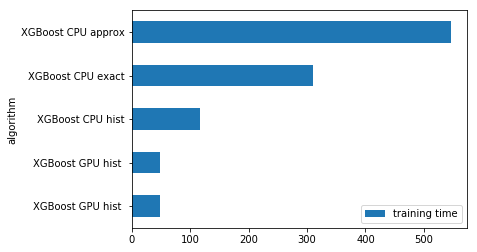

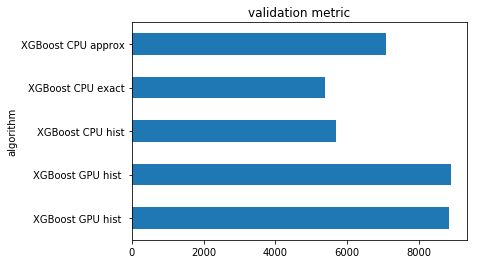

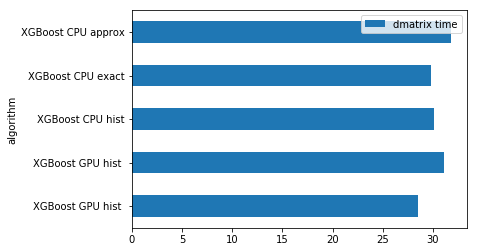

/home/arno/.pyenv/versions/3.6.0/lib/python3.6/json/encoder.py:199: DeprecationWarning: Interpreting naive datetime as local 2017-06-12 13:10:09.326889. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


In [33]:
data.plot(label="training time",kind='barh',x='algorithm',y='training time')
data.plot(title="validation metric",kind='barh',x='algorithm',y='validation metric',legend=False)
data.plot(label="dmatrix time",kind='barh',x='algorithm',y='dmatrix time')

## Now call XGBoost from H2O

In [34]:
import h2o
from h2o.estimators import H2OXGBoostEstimator
h2o.init()

t_start = time.time()
df_hex = h2o.import_file(path)
print("Time to parse by H2O (sec): ", time.time() - t_start)

for c in drop_cols:
    df_hex = df_hex.drop(c, axis=1)

## Note: Frame contains categorical columns
## H2O internally handles them according to the 'categorical_encoding' parameter
trainhex = df_hex[:trainrows,:]
testhex  = df_hex[trainrows:,:]
trainhex[target] = (trainhex[target]).asfactor()
testhex[target] = (testhex[target]).asfactor()

Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
  Java Version: java version "1.8.0_101"; Java(TM) SE Runtime Environment (build 1.8.0_101-b13); Java HotSpot(TM) 64-Bit Server VM (build 25.101-b13, mixed mode)
  Starting server from /home/arno/.pyenv/versions/3.6.0/envs/h2oai/lib/python3.6/site-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmpsev111gz
  JVM stdout: /tmp/tmpsev111gz/h2o_arno_started_from_python.out
  JVM stderr: /tmp/tmpsev111gz/h2o_arno_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321... successful.


H2O cluster uptime:,05 secs
H2O cluster version:,3.11.0.266
H2O cluster version age:,13 days
H2O cluster name:,H2O_from_python_arno_yp2esb
H2O cluster total nodes:,1
H2O cluster free memory:,26.67 Gb
H2O cluster total cores:,40
H2O cluster allowed cores:,40
H2O cluster status:,"accepting new members, healthy"
H2O connection url:,http://127.0.0.1:54321
H2O connection proxy:,None


Parse progress: |█████████████████████████████████████████████████████████| 100%
Time to parse by H2O (sec):  16.542898654937744


/home/arno/.pyenv/versions/3.6.0/lib/python3.6/json/encoder.py:199: DeprecationWarning: Interpreting naive datetime as local 2017-06-12 13:26:49.984875. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


In [36]:
def runH2OXGBoost(param):
    label = "H2O XGBoost " \
    + ("GPU" if "backend" in param.keys() and "gpu"==param["backend"] else "CPU") \
    + (" " + param["tree_method"] if "tree_method" in param.keys() else "")
    print(label)
    print("=====================")
    for k, v in param.items():
        print(k, v)
    print("=====================")
        
    t_start = time.time()
    model = H2OXGBoostEstimator(**param)
    model.train(x = list(cols), y = target, training_frame = trainhex)
    tt = time.time() - t_start
    print("Time to train (sec): ", tt)
    h2o_train_times.append(tt)

    t_start = time.time()
    preds = model.predict(testhex)[:,2]
    tt = time.time() - t_start
    print("Time to predict (sec): ", tt)
    h2o_score_times.append(tt)

    preds = h2o.as_list(preds)
    labels = test_target.values
    #auc = metrics.roc_auc_score(labels, preds)
    #print("AUC:", auc)
    rmse = np.sqrt(metrics.mean_squared_error(labels, preds))
    print("RMSE:", rmse)
    
    h2o_valid_metrics.append(rmse)
    h2o_plot_labels.append(label)
    
    #pd.DataFrame(model.varimp(),columns=["Feature","","Importance",""]).head(10).plot(label='importance',kind="barh",x="Feature",y="Importance").invert_yaxis()    

/home/arno/.pyenv/versions/3.6.0/lib/python3.6/json/encoder.py:199: DeprecationWarning: Interpreting naive datetime as local 2017-06-12 13:49:00.636621. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


In [37]:
h2o_valid_metrics = []
h2o_train_times = []
h2o_score_times = []
h2o_plot_labels = []

/home/arno/.pyenv/versions/3.6.0/lib/python3.6/json/encoder.py:199: DeprecationWarning: Interpreting naive datetime as local 2017-06-12 13:49:02.850956. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


In [ ]:
param = {
    "ntrees":num_round
    , "max_depth":max_depth
    , "eta":learn_rate
    , "subsample":0.7
    , "colsample_bytree":0.9
    , "min_child_weight":5
    , "seed":12345
    , "score_tree_interval":num_round
    , "backend":"cpu"
    , "tree_method":"exact"
}
runH2OXGBoost(param)

In [ ]:
param = {
    "ntrees":num_round
    , "max_depth":max_depth
    , "eta":learn_rate
    , "subsample":0.7
    , "colsample_bytree":0.9
    , "min_child_weight":5
    , "seed":12345
    , "score_tree_interval":num_round
    , "backend":"cpu"
    , "tree_method":"approx"
}
runH2OXGBoost(param)

In [ ]:
param = {
    "ntrees":num_round
    , "max_depth":max_depth
    , "eta":learn_rate
    , "subsample":0.7
    , "colsample_bytree":0.9
    , "min_child_weight":5
    , "seed":12345
    , "score_tree_interval":num_round
    , "backend":"cpu"
    , "tree_method":"hist"
}
runH2OXGBoost(param)

In [ ]:
param = {
    "ntrees":num_round
    , "max_depth":max_depth
    , "learn_rate":learn_rate
    , "sample_rate":0.7
    , "col_sample_rate_per_tree":0.9
    , "min_rows":5
    , "seed":12345
    , "score_tree_interval":num_round
    , "backend":"gpu"
    , "tree_method":"exact"
}
runH2OXGBoost(param)

In [ ]:
param = {
    "ntrees":num_round
    , "max_depth":max_depth
    , "learn_rate":learn_rate
    , "sample_rate":0.7
    , "col_sample_rate_per_tree":0.9
    , "min_rows":5
    , "seed":12345
    , "score_tree_interval":num_round
    , "backend":"gpu"
    , "tree_method":"hist"
}
runH2OXGBoost(param)

## H2O GBM (CPU)

In [ ]:
from h2o.estimators.gbm import H2OGradientBoostingEstimator
param = {
      "ntrees":num_round
    , "max_depth":max_depth
    , "learn_rate":learn_rate
    , "sample_rate":0.7
    , "col_sample_rate_per_tree":0.9
    , "min_rows":5
    , "seed":12345
    , "score_tree_interval":num_round
}

t_start = time.time()
model = H2OGradientBoostingEstimator(**param)
model.train(x = list(cols), y = target, training_frame = trainhex)
tt = time.time() - t_start
print("Time to train (sec): ", tt)
h2o_train_times.append(tt)

t_start = time.time()
preds = model.predict(testhex)[:,2]
tt = time.time() - t_start
print("Time to predict (sec): ", tt)
h2o_score_times.append(tt)

preds = h2o.as_list(preds)
labels = test_target.values
#auc = metrics.roc_auc_score(labels, preds)
#print("AUC:", auc)
rmse = np.sqrt(metrics.mean_squared_error(labels, preds))
print("RMSE:", rmse)

h2o_valid_aucs.append(auc)
h2o_plot_labels.append("H2O GBM CPU")

# Show variable importance for the H2O GBM model
#pd.DataFrame(model.varimp(),columns=["Feature","","Importance",""]).head(10).plot(label='importance',kind="barh",x="Feature",y="Importance").invert_yaxis()

In [ ]:
data = pd.DataFrame({'algorithm'  :h2o_plot_labels,
                     'training time':h2o_train_times,
                     'scoring time':h2o_score_times,
                     'validation metric' :h2o_valid_metrics}).sort_values(by="training time")
data

In [ ]:
data.plot(label="DMatrix + training time",kind='barh',x='algorithm',y='training time')
data.plot(title="validation metric",kind='barh',x='algorithm',y='validation metric',legend=False)